In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, TimeDistributed, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate  # Adjusted import statement
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional




from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import os
import sys
module_path = '/content/drive/MyDrive/myproject'
if module_path not in sys.path:
    sys.path.append(module_path)

from util.dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings('ignore')

# To calculate on GPU
# Allow TensorFlow to use GPU memory efficiently
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# CONSTANTS
seed = 42
lr = 0.0001
batch = 64

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val, vocab_size, emdedding_size, vectors = get_data()

NaN values in concatenated dataset's rating column: 0


In [ ]:
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))
print('Val labels: ', collections.Counter(y_val))

Train labels:  Counter({1: 3021, 0: 3020})
Test labels:  Counter({0: 863, 1: 863})
Val labels:  Counter({0: 432, 1: 431})


In [ ]:
train_max = X_train.max()
test_max = X_test.max()
val_max = X_val.max()
max_all = max([train_max, test_max, val_max])
input_dim = max_all+1
output_dim = 32

In [ ]:
# Concatinate train and validation to be used in cross validation
Xtrain_concat = np.concatenate((X_train,X_val),axis=0)
ytrain_concat = np.concatenate((y_train,y_val),axis=0)

## Cross validation setup

In [ ]:
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True)
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
adamOptimizer = Adam(learning_rate=lr)

In [ ]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title, modelname):
    pp = PdfPages(modelname)
    plt.figure()
    history = history_arrs[0]
    plt.plot(history[train])
    plt.plot(history[val])
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(['Train', 'Validation'], loc='upper left')
    pp.savefig()
    plt.show()
    pp.close()

In [ ]:
def run_test(model_func, Xtrain, ytrain, embedding_layer):
    results = []
    best_acc = 0
    for i,(train_index, val_index)in enumerate(sk.split(Xtrain, ytrain)):
        if embedding_layer == 'nowv':
            el = Embedding(input_dim, output_dim, trainable = True)
        elif embedding_layer == 'wv':
            el = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(el)
        history = model.fit(Xt, yt, epochs=15, batch_size=batch, verbose = 0)
        loss, acc = model.evaluate(Xv, yv, verbose=0, batch_size=batch)
        print('Accuracy for iteration %d: %.4f' % (i, acc))
        results.append(acc)
    results = np.array(results)
    return results

In [ ]:
def create_model(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 2))
    model.add(Conv1D(64, 2))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(1, activation='sigmoid'))

    # Create a new Adam optimizer instance for each model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model




In [ ]:
def calculate_metrics(model, X_test, y_test):
    # Use model.predict() and apply a threshold of 0.5 for class predictions
    ypred_prob = model.predict(X_test, verbose=0)
    ypred_class = (ypred_prob >= 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)

    return accuracy, precision, recall, f1, conf_matrix


In [ ]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix,
    index=['true:positive', 'true:negative'],
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

## Cross-validation without pretrained word vectors

In [ ]:
results = run_test(create_model, Xtrain_concat, ytrain_concat, 'nowv')
print('Average model 1 accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model 1 accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8584
Accuracy for iteration 1: 0.8631
Accuracy for iteration 2: 0.8601
Average model 1 accuracy of cross validation without word vectors: 0.8605
Standard deviation of the accuracy: 0.0020
The best model 1 accuracy of cross validation without word vectors: 0.8631


# Evaluation without pretrained word vectors

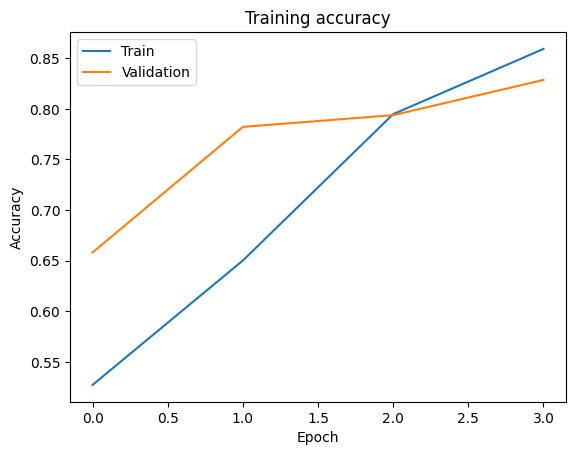

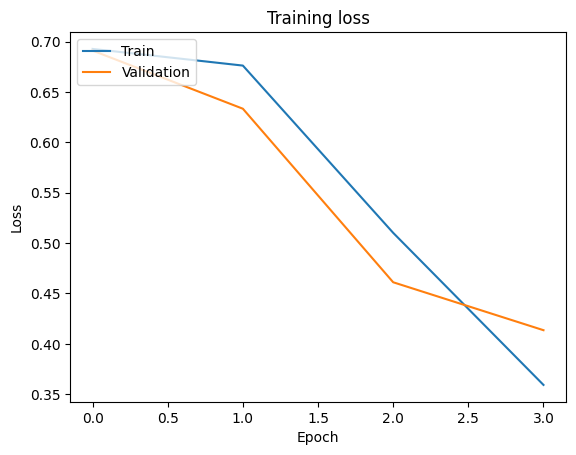

Model statistics with class predictions: 
Accuracy: 0.8302
Precision: 0.8501
Recall: 0.8019
F1 score: 0.8253
Confusion matrix:
               pred:positive  pred:negative
true:positive            741            122
true:negative            171            692


In [ ]:
embedding_layer = Embedding(input_dim, output_dim, trainable = True)
model = create_model(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'cnnbilstm1-nowv-acc.pdf')
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'cnnbilstm1-nowv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [ ]:
model.save('/content/drive/MyDrive/myproject/models/cnnbilstm-nowv.keras')

Cross-validation with pretrained word vectors



In [ ]:
results = run_test(create_model, Xtrain_concat, ytrain_concat, 'wv')
print('Average model 1 accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model 1 accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8853
Accuracy for iteration 1: 0.8601
Accuracy for iteration 2: 0.8674
Average model 1 accuracy of cross validation without word vectors: 0.8709
Standard deviation of the accuracy: 0.0106
The best model 1 accuracy of cross validation without word vectors: 0.8853



Evaluation with pretrained word vectors

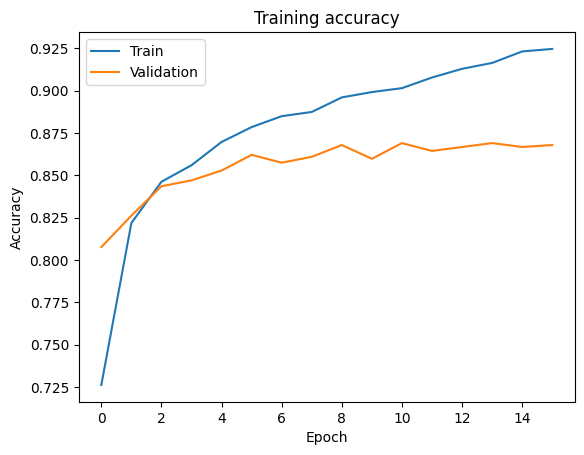

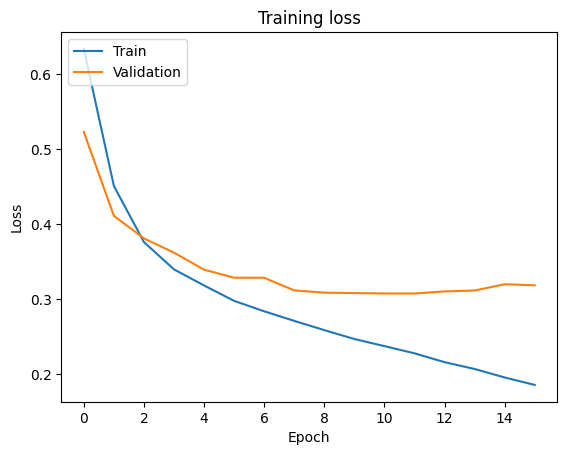

Model statistics with class predictions: 
Accuracy: 0.8720
Precision: 0.8896
Recall: 0.8494
F1 score: 0.8690
Confusion matrix:
               pred:positive  pred:negative
true:positive            772             91
true:negative            130            733


In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
model = create_model(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'cnnbilstm1-wv-acc.pdf')
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'cnnbilstm1-wv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [ ]:
model.save('/content/drive/MyDrive/myproject/models/cnnbilstm-wv.keras')

## Model evaluation tests on IMDB dataset

In [ ]:
# IMDB dataset
from keras.datasets import imdb
word_count = 5000
skip_words = 20
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count, skip_top = skip_words)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model performance evaluation

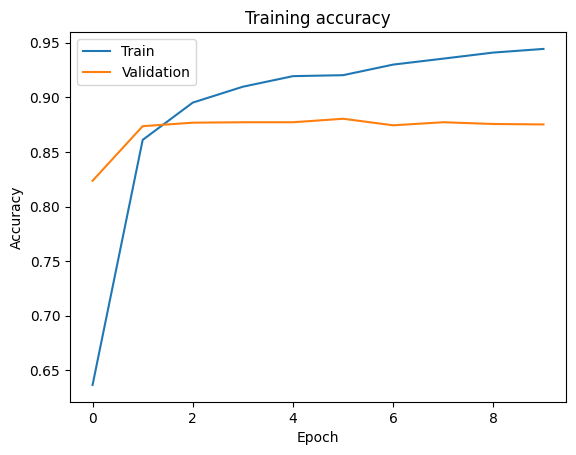

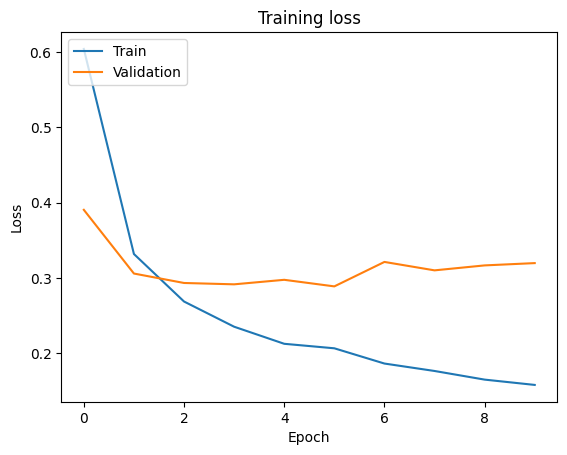

Model statistics with class predictions: 
Accuracy: 0.8735
Precision: 0.8781
Recall: 0.8675
F1 score: 0.8728
Confusion matrix:
               pred:positive  pred:negative
true:positive          10994           1506
true:negative           1656          10844


In [ ]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = create_model(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'imdb_cnnbilstm1-acc.pdf')
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'imdb_cnnbilstm1-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)